# Team 42 - Notebook - June 25

**Hackathon Challenges (Thursday)**

1. Evaluate two interpretation methods for your machine learning solution
2. Compare interpretation of baseline with your approach
3. Submit best results on project to leaderboard
4. Prepare 2 Google Slides on team's approach and submit them 

In [ ]:
%%capture
! pip install numpy scipy matplotlib xarray pandas netcdf4 tqdm tensorflow scikit-learn seaborn xgboost

In [ ]:
%%capture
pip install --upgrade pandas

In [ ]:
import s3fs
import seaborn as sns
import pandas as pd
import pyarrow
import re
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from os.path import join, exists
from matplotlib.colors import LogNorm

import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GroupKFold, GridSearchCV
from sklearn.multioutput import MultiOutputRegressor
from sklearn.linear_model import LinearRegression, ElasticNet, Lasso, Ridge, BayesianRidge, LassoLarsIC
from sklearn.kernel_ridge import KernelRidge
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, RNN, LSTM, SimpleRNN, Conv1D, MaxPooling1D, Flatten, BatchNormalization
from tensorflow.keras.models import Model, Sequential

from tensorflow.keras.optimizers import Adam

In [ ]:
# Fix the random state
seed = 8886
np.random.seed(seed)
random.seed(seed)
tf.random.set_seed(seed)

In [ ]:
# -----------------------------------------------
""" Data Processing """

def fetch_data(f):
    """ Load data directly from Amazon S3 storage """
    
    obj = fs.open(f)
    df = pd.read_parquet(obj)
    return df

# def prepare_data(data, input_columns, output_columns):
#     """ Splits data to input/output with corresponding lag """
    
#     data['id'] = data['id'].apply(lambda x: int(x[3:])) # change expnumber to int for sorting
#     data.index.name = 'indx'
#     data = data.sort_values(['id','indx'])
#     x_data = data[input_columns].iloc[:-1, :]
#     y_data = data[output_columns].iloc[1:, :]
    
#     return x_data, y_data

def prepare_data(data, input_columns, output_columns):
    """ Splits data to input/output with corresponding lag """
    data['id'] = data['id'].apply(lambda x: int(x[3:])) # change expnumber to int for sorting
    data.index.name = 'indx'
    data = data.sort_values(['id','indx'])
    # lag in/out by experiment
    mask = (data['Time [s]'] != data['Time [s]'].max())
    x_data = data.loc[mask, input_columns]
    mask = (data['Time [s]'] != data['Time [s]'].min())
    y_data = data.loc[mask, output_columns]
    return x_data, y_data

def get_starting_conds(data, input_vars, exp, starting_ts=0):
    """ Take data and expiriment number to gather initial starting condition for box emulator"""
    exp_data = data[data['id'] == exp]
    
    if exp_data.shape[0] == 0:
        raise ValueError('That expiriment number does not exist in this dataset.')
    
    ts_data = exp_data.iloc[starting_ts:starting_ts+1, :]

    return ts_data

# -----------------------------------------------
""" Evaluation """

def calc_pdf_hist(x, x_bins):
    return np.histogram(x, x_bins, density=True)[0]

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def hellinger(x, pdf_p, pdf_q):
    pdf_distances = (np.sqrt(pdf_p) - np.sqrt(pdf_q)) ** 2
    return np.trapz(pdf_distances, x) / 2

def hellinger_distance(y_true, y_pred, bins=50):
    bin_points = np.linspace(np.minimum(y_true.min(), y_pred.min()),
                       np.maximum(y_true.max(), y_pred.max()),
                       bins)
    bin_centers = 0.5 * (bin_points[:-1] + bin_points[1:])
    y_true_pdf = calc_pdf_hist(y_true, bin_points)
    y_pred_pdf = calc_pdf_hist(y_pred, bin_points)
    return hellinger(bin_centers, y_true_pdf, y_pred_pdf)

def r2_corr(y_true, y_pred):
    return np.corrcoef(y_true, y_pred)[0, 1] ** 2

def evaluate_mod(true_output, model_results):
    
    print('RMSE: Precursor: {:.5f}, Gas: {:.5f}, Aerosols: {:.5f}'.format(
        rmse(true_output.iloc[:,0], model_results.iloc[:,0]),
        rmse(true_output.iloc[:,1], model_results.iloc[:,1]),
        rmse(true_output.iloc[:,2], model_results.iloc[:,2])))
    print('R2: Precursor: {:.5f}, Gas: {:.5f}, Aerosols: {:.5f}'.format(
        r2_corr(true_output.iloc[:,0], model_results.iloc[:,0]),
        r2_corr(true_output.iloc[:,1], model_results.iloc[:,1]),
        r2_corr(true_output.iloc[:,2], model_results.iloc[:,2])))
    print('Hellenger Distance: Precursor: {:.5f}, Gas: {:.5f}, Aerosols: {:.5f}'.format(
        hellinger_distance(true_output.iloc[:,0], model_results.iloc[:,0]),
        hellinger_distance(true_output.iloc[:,1], model_results.iloc[:,1]),
        hellinger_distance(true_output.iloc[:,2], model_results.iloc[:,2])))
    
    return

# -----------------------------------------------
""" Models """
def dense_neural_net(num_layers=2, num_neurons=100, activation="relu", learning_rate=0.001,
                     num_input_columns=9, num_output_columns=3):
    """ Build and return dense neural network with specified hyperparameters"""
    
    input_layer = Input(num_input_columns)
    n_net = input_layer
    for l in range(num_layers):
        n_net= Dense(num_neurons, activation=activation)(n_net)
    out = Dense(num_output_columns)(n_net)
    mod = Model(input_layer, out)
    mod.compile(Adam(learning_rate=learning_rate), "mse")
    
    return mod


def box_emulator(neural_network, starting_conds, input_scaler, output_scaler, num_timesteps=1439):
    """ Forward box emulator
    Args:
        neural_netwrok: NN model object that predits output at t+1
        starting_conds: Initial input conditions used for first prediction
        input_scaler: Input scaler object
        onput_scaler: Onput scaler object
        num_timesteps: how many timesteps forward to run emulator
    Returns:
        results: Pandas DataFrame of box emulator output
    """
    mod = neural_network
    scaled_input = input_scaler.transform(starting_conds.iloc[:,1:-1])
    static_input = scaled_input[:,-6:]

    for i in range(num_timesteps):

        if i == 0:

            pred = mod.predict(scaled_input)
            new_input = np.concatenate([pred,static_input], axis=1)
            pred_array = pred

        else:

            pred = mod.predict(new_input)
            new_input = np.concatenate([pred,static_input], axis=1)
            pred_array = np.concatenate([pred_array, pred], axis=0)
            
    results = pd.DataFrame(output_scaler.inverse_transform(pred_array))
    results['id'] = starting_conds.iloc[0,-1]
    results.columns = starting_conds.columns[[1,2,3,-1]]
    return results


def run_emulator_ensemble(input_data, output_data, mod, num_expiriments, input_vars, input_scaler, 
                          output_scaler, run_length=1439):
    """ Run an ensemble of emulators on n amount of random expiriments
    Args:
        input_data: unscaled dataframe collection of expiriment data
        mod: NN model object that predits output at t+1
        num_expiriments: How many expiriments to run
        input_vars: Input variables for model
        output_vars: Output variables for model
        run_length: number of timesteps to run each emulator forward
    Returns:
        pred_df: Aggregated Pandas DataFrame of predictions for each expiriment
        true_df: Corresponding Dataframe with raw expiriment data
    """
    output_cols = input_data.columns[[1,2,3, -1]]
    exps = sorted(random.sample(list(input_data['id'].unique()), num_expiriments))
    pred_df  = pd.DataFrame(columns = output_cols)
    true_df = output_data.loc[output_data['id'].isin(exps)].iloc[:,1:-1].reset_index(drop=True) 

    for i in range(num_expiriments):

        init_conds = get_starting_conds(input_data, input_vars, exps[i])
        preds = box_emulator(mod, init_conds, input_scaler, output_scaler, run_length)
        preds['id'] = exps[i]
        preds.columns = pred_df.columns
        pred_df = pred_df.append(preds, ignore_index=True)
      
    return pred_df, true_df

In [ ]:
# Functions for RNN

def box_emulator2(neural_network, starting_conds, input_scaler, output_scaler, num_timesteps=1439):

    mod = neural_network
    scaled_input = input_scaler.transform(starting_conds.iloc[:,1:-1])
    static_input = scaled_input[:,-6:]

    for i in range(num_timesteps):

        if i == 0:

            scaled_input = np.reshape(scaled_input, (scaled_input.shape[0], 1, scaled_input.shape[1]))
            pred = mod.predict(scaled_input)
            new_input = np.concatenate([pred,static_input], axis=1)
            pred_array = pred

        else:

            new_input = np.reshape(new_input, (new_input.shape[0], 1, new_input.shape[1]))
            pred = mod.predict(new_input)
            new_input = np.concatenate([pred,static_input], axis=1)
            pred_array = np.concatenate([pred_array, pred], axis=0)
            
    results = pd.DataFrame(output_scaler.inverse_transform(pred_array))
    results['id'] = starting_conds.iloc[0,-1]
    results.columns = starting_conds.columns[[1,2,3,-1]]
    return results


def run_emulator_ensemble2(input_data, output_data, mod, num_expiriments, input_vars, input_scaler, 
                          output_scaler, run_length=1439):
    output_cols = input_data.columns[[1,2,3, -1]]
    exps = sorted(random.sample(list(input_data['id'].unique()), num_expiriments))
    pred_df  = pd.DataFrame(columns = output_cols)
    true_df = output_data.loc[output_data['id'].isin(exps)].iloc[:,1:-1].reset_index(drop=True) 

    for i in range(num_expiriments):

        init_conds = get_starting_conds(input_data, input_vars, exps[i])
        preds = box_emulator2(mod, init_conds, input_scaler, output_scaler, run_length)
        preds['id'] = exps[i]
        preds.columns = pred_df.columns
        pred_df = pred_df.append(preds, ignore_index=True)
      
    return pred_df, true_df

In [ ]:
# Functions for CNN

def box_emulator3(neural_network, starting_conds, input_scaler, output_scaler, num_timesteps=1439):

    mod = neural_network
    scaled_input = input_scaler.transform(starting_conds.iloc[:,1:-1])
    static_input = scaled_input[:,-6:]

    for i in range(num_timesteps):

        if i == 0:

            scaled_input = np.reshape(scaled_input, (scaled_input.shape[0], scaled_input.shape[1], 1))
            pred = mod.predict(scaled_input)
            new_input = np.concatenate([pred,static_input], axis=1)
            pred_array = pred

        else:

            new_input = np.reshape(new_input, (new_input.shape[0], new_input.shape[1], 1))
            pred = mod.predict(new_input)
            new_input = np.concatenate([pred,static_input], axis=1)
            pred_array = np.concatenate([pred_array, pred], axis=0)
            
    results = pd.DataFrame(output_scaler.inverse_transform(pred_array))
    results['id'] = starting_conds.iloc[0,-1]
    results.columns = starting_conds.columns[[1,2,3,-1]]
    return results


def run_emulator_ensemble3(input_data, output_data, mod, num_expiriments, input_vars, input_scaler, 
                          output_scaler, run_length=1439):
    output_cols = input_data.columns[[1,2,3, -1]]
    exps = sorted(random.sample(list(input_data['id'].unique()), num_expiriments))
    pred_df  = pd.DataFrame(columns = output_cols)
    true_df = output_data.loc[output_data['id'].isin(exps)].iloc[:,1:-1].reset_index(drop=True) 

    for i in range(num_expiriments):

        init_conds = get_starting_conds(input_data, input_vars, exps[i])
        preds = box_emulator3(mod, init_conds, input_scaler, output_scaler, run_length)
        preds['id'] = exps[i]
        preds.columns = pred_df.columns
        pred_df = pred_df.append(preds, ignore_index=True)
      
    return pred_df, true_df

In [ ]:
# Load data

fs = s3fs.S3FileSystem(anon=True)
gecko_files = fs.ls("ncar-aiml-data-commons/gecko/")[1:]
test, train, val = map(fetch_data, gecko_files)

In [ ]:
# Split data into training, validation, and test set
# Apply scalers to the data

input_vars, output_vars = train.columns, train.columns[[0,1,2,3,-1]]

train_in, train_out = prepare_data(train, input_vars, output_vars)
val_in, val_out = prepare_data(val, input_vars, output_vars)
test_in, test_out = prepare_data(test, input_vars, output_vars)

input_scaler = MinMaxScaler()
output_scaler = MinMaxScaler()
# input_scaler = StandardScaler()
# output_scaler = StandardScaler()
# input_scaler = RobustScaler()
# output_scaler = RobustScaler()

# Fit scalers using training set only
scaled_train_in = input_scaler.fit(train_in.iloc[:,1:-1])
scaled_train_out = output_scaler.fit(train_out.iloc[:,1:-1])

# Transform training, validation, and testing set
scaled_train_in = input_scaler.transform(train_in.iloc[:,1:-1])
scaled_train_out = output_scaler.transform(train_out.iloc[:,1:-1])
scaled_val_in = input_scaler.transform(val_in.iloc[:,1:-1])
scaled_val_out = output_scaler.transform(val_out.iloc[:,1:-1])
scaled_test_in = input_scaler.transform(test_in.iloc[:,1:-1])
scaled_test_out = output_scaler.transform(test_out.iloc[:,1:-1])

print(scaled_train_in.shape, scaled_train_out.shape)
print(scaled_val_in.shape, scaled_val_out.shape)
print(scaled_test_in.shape, scaled_test_out.shape)

(2014600, 9) (2014600, 3)
(287800, 9) (287800, 3)
(287800, 9) (287800, 3)


In [ ]:
# Define some neural network models

# Dense neural network model in the original Notebook
def Model_Dense(num_layers=2, num_neurons=100, activation="relu", learning_rate=0.001,
                num_input_columns=9, num_output_columns=3):
  input_layer = Input(num_input_columns)
  n_net = input_layer
  for i in range(num_layers):
    n_net = Dense(num_neurons, activation=activation)(n_net)
  out = Dense(num_output_columns)(n_net)
  model = Model(input_layer, out)
  model.compile(Adam(learning_rate=learning_rate), "mse", metrics=["accuracy"])

  return model


# RNN model (cuDNN)
def Model_cuDNN():

  model = Sequential()
  model.add(LSTM(128, activation="tanh", recurrent_activation="sigmoid",
                 recurrent_dropout=0, unroll=False, use_bias=True, input_shape=(1,9)))
  model.add(Dense(3))
  model.compile(Adam(learning_rate=0.001), "mse", metrics=["accuracy"])

  return model


def Model_cuDNN2():

  model = Sequential()
  model.add(LSTM(64, activation="tanh", recurrent_activation="sigmoid",
                 recurrent_dropout=0, unroll=False, use_bias=True, input_shape=(1,9)))
  model.add(Dense(3))
  model.compile(Adam(learning_rate=0.001), "mse", metrics=["accuracy"])

  return model


# RNN model (LSTM)
def Model_LSTM(num_layers=3, num_neurons=100):
  assert num_layers >= 1

  activation = "softmax"
  recurrent_activation = "tanh"
  recurrent_dropout = 0.0

  model = Sequential()
  model.add(LSTM(num_neurons, activation=activation, recurrent_activation=recurrent_activation,
                recurrent_dropout=recurrent_dropout, input_shape=(1,9), return_sequences=True))
  if num_layers >= 3:
    for i in range(num_layers-2):
      model.add(LSTM(num_neurons, activation=activation, recurrent_activation=recurrent_activation,
                    recurrent_dropout=recurrent_dropout, return_sequences=True))
    model.add(LSTM(num_neurons, activation=activation, recurrent_activation=recurrent_activation))
  else:
    model.add(LSTM(num_neurons, activation=activation, recurrent_activation=recurrent_activation))
  model.add(Dense(3))
  model.compile(Adam(learning_rate=0.001), "mse", metrics=["accuracy"])

  return model


def Model_LSTM2():

   model = Sequential()
   model.add(LSTM(128, input_shape=(1,9)))
   model.add(Dense(256, activation="linear"))
   model.add(Dense(128, activation="linear"))
   model.add(Dense(3))
   model.compile(Adam(learning_rate=0.001), "mse", metrics=["accuracy"])

   return model


def Model_Conv1D():

  model = Sequential()
  model.add(Conv1D(32, 6, activation='relu', input_shape=(9, 1)))
  model.add(Conv1D(32, 3, activation='relu'))
  # model.add(MaxPooling1D())
  model.add(Conv1D(32, 2, activation='relu'))
  # model.add(MaxPooling1D())
  # model.add(Conv1D(16, 3, activation='relu'))
  # model.add(MaxPooling1D())
  # model.add(Conv1D(16, 2, activation='relu'))
  # model.add(MaxPooling1D())
  model.add(Flatten())
  # model.add(Dense(100, activation='relu'))
  # model.add(BatchNormalization())
  # model.add(Dense(100, activation='relu'))
  # model.add(BatchNormalization())
  model.add(Dense(100, activation='relu'))
  model.add(BatchNormalization())
  model.add(Dense(3, activation='softmax'))
  model.compile(Adam(learning_rate=0.001), "mse", metrics=["accuracy"])

  return model

In [ ]:
# Linear models
model_Ridge = Ridge()
model_Lasso = Lasso(alpha=0.005)
model_ENet = ElasticNet(alpha=0.005)

# Polynomial Regression : If you use this, the kernel crashes.
model_PolynomialRegression = Pipeline([('poly', PolynomialFeatures(degree=3)), ('linear', LinearRegression(fit_intercept=False))])

# Kernel Rigde : If you use this, the kernel crashes.
model_KernelRidge = KernelRidge(alpha=0.05, kernel="polynomial", degree=2)

In [ ]:
X_train = np.copy(scaled_train_in)
y_train = np.copy(scaled_train_out)

X_validate = np.copy(scaled_val_in)
y_validate = np.copy(scaled_val_out)

X_test = np.copy(scaled_test_in)
y_test = np.copy(scaled_test_out)

In [ ]:
model_LinearRegression = LinearRegression()
model_LinearRegression.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [ ]:
model_RandomForest = RandomForestRegressor(criterion="mse", bootstrap=True, n_estimators=50, max_depth=10, n_jobs=-1, verbose=1)
model_RandomForest.fit(X_train, y_train)

In [ ]:
model_RandomForest2 = RandomForestRegressor(criterion="mse", bootstrap=True, n_estimators=100, max_depth=30, n_jobs=-1, verbose=1)
model_RandomForest2.fit(X_train, y_train)

In [ ]:
model_MultiRandomForest = MultiOutputRegressor(RandomForestRegressor(criterion="mse", bootstrap=True, n_estimators=50, max_depth=10, n_jobs=-1, verbose=1))
model_MultiRandomForest.fit(X_train, y_train)

In [ ]:
model_MultiGradientBoost = MultiOutputRegressor(GradientBoostingRegressor(n_estimators=50, learning_rate=0.05, max_depth=10, verbose=1))
model_MultiGradientBoost.fit(X_train, y_train)

In [ ]:
model_MultiMLPRegressor = MultiOutputRegressor(MLPRegressor(100, activation="relu", solver="adam", alpha=0.0001, verbose=1))
model_MultiMLPRegressor.fit(X_train, y_train)

In [ ]:
tf.random.set_seed(seed)
model_Dense = Model_Dense()
model_Dense.summary()
history = model_Dense.fit(X_train, y_train, validation_data=(X_validate, y_validate), batch_size=256, epochs=10, verbose=1)

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 9)]               0         
_________________________________________________________________
dense_45 (Dense)             (None, 100)               1000      
_________________________________________________________________
dense_46 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_47 (Dense)             (None, 3)                 303       
Total params: 11,403
Trainable params: 11,403
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
7870/7870 [==============================] - 30s 4ms/step - loss: 2.7216e-04 - accuracy: 0.9945 - val_loss: 4.1162e-06 - val_accuracy: 0.9987
Epoch 2/10
7870/7870 [==============================] - 30s 4ms/step - loss: 3.1870e-06 - accuracy: 

In [ ]:
tf.random.set_seed(seed)
model_Dense2 = Model_Dense(num_layers=10)
model_Dense2.summary()
history = model_Dense2.fit(X_train, y_train, validation_data=(X_validate, y_validate), batch_size=256, epochs=10, verbose=1)

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 9)]               0         
_________________________________________________________________
dense_48 (Dense)             (None, 100)               1000      
_________________________________________________________________
dense_49 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_50 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_51 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_52 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_53 (Dense)             (None, 100)               1010

In [ ]:
tf.random.set_seed(seed)
model_Dense3 = Model_Dense(num_neurons=1000)
model_Dense3.summary()
history = model_Dense3.fit(X_train, y_train, validation_data=(X_validate, y_validate), batch_size=256, epochs=10, verbose=1)

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 9)]               0         
_________________________________________________________________
dense_59 (Dense)             (None, 1000)              10000     
_________________________________________________________________
dense_60 (Dense)             (None, 1000)              1001000   
_________________________________________________________________
dense_61 (Dense)             (None, 3)                 3003      
Total params: 1,014,003
Trainable params: 1,014,003
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
7870/7870 [==============================] - 46s 6ms/step - loss: 5.1762e-05 - accuracy: 0.9967 - val_loss: 5.4611e-06 - val_accuracy: 0.9980
Epoch 2/10
7870/7870 [==============================] - 47s 6ms/step - loss: 4.4897e-06 - accu

In [ ]:
tf.random.set_seed(seed)
model_Dense4 = Model_Dense(num_layers=20, num_neurons=500)
model_Dense4.summary()
history = model_Dense4.fit(X_train, y_train, validation_data=(X_validate, y_validate), batch_size=256, epochs=10, verbose=1)

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 9)]               0         
_________________________________________________________________
dense_62 (Dense)             (None, 500)               5000      
_________________________________________________________________
dense_63 (Dense)             (None, 500)               250500    
_________________________________________________________________
dense_64 (Dense)             (None, 500)               250500    
_________________________________________________________________
dense_65 (Dense)             (None, 500)               250500    
_________________________________________________________________
dense_66 (Dense)             (None, 500)               250500    
_________________________________________________________________
dense_67 (Dense)             (None, 500)               2505

Now run the emulated box models for each ML methods.

In [ ]:
num_exps = 5

In [ ]:
random.seed(seed)
pred_box_LinearRegression, true_box_LinearRegression = run_emulator_ensemble(test_in, test_out, model_LinearRegression, num_exps, input_vars, input_scaler, output_scaler)

In [ ]:
# %%capture
# random.seed(seed)
# pred_box_RandomForest, true_box_RandomForest = run_emulator_ensemble(test_in, test_out, model_RandomForest, num_exps, input_vars, input_scaler, output_scaler)

In [ ]:
# %%capture
# random.seed(seed)
# pred_box_MultiGradientBoost, true_box_MultiGradientBoost = run_emulator_ensemble(test_in, test_out, model_MultiGradientBoost, num_exps, input_vars, input_scaler, output_scaler)

In [ ]:
random.seed(seed)
pred_box_Dense, true_box_Dense = run_emulator_ensemble(test_in, test_out, model_Dense, num_exps, input_vars, input_scaler, output_scaler)

In [ ]:
random.seed(seed)
pred_box_Dense2, true_box_Dense2 = run_emulator_ensemble(test_in, test_out, model_Dense2, num_exps, input_vars, input_scaler, output_scaler)

In [ ]:
random.seed(seed)
pred_box_Dense3, true_box_Dense3 = run_emulator_ensemble(test_in, test_out, model_Dense3, num_exps, input_vars, input_scaler, output_scaler)

In [ ]:
random.seed(seed)
pred_box_Dense4, true_box_Dense4 = run_emulator_ensemble(test_in, test_out, model_Dense4, num_exps, input_vars, input_scaler, output_scaler)

Metrics for base model:
RMSE: Precursor: 0.00010, Gas: 0.00017, Aerosols: 0.00008
R2: Precursor: 0.99990, Gas: 0.99995, Aerosols: 0.99999
Hellenger Distance: Precursor: 0.00001, Gas: 0.00001, Aerosols: 0.00001

Metrics for Box Emulator:
RMSE: Precursor: 0.00500, Gas: 0.02494, Aerosols: 0.01381
R2: Precursor: 0.82047, Gas: 0.65767, Aerosols: 0.74146
Hellenger Distance: Precursor: 0.31740, Gas: 0.31260, Aerosols: 0.35933




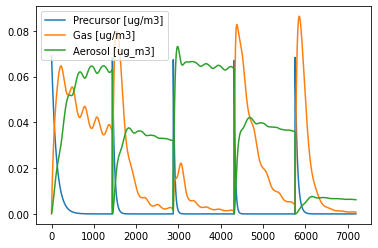

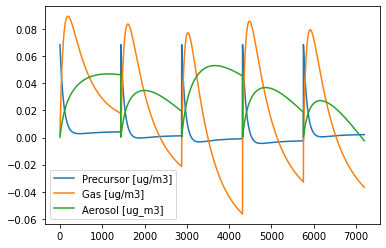

In [ ]:
# model_LinearRegression

pred_nn_LinearRegression = pd.DataFrame(output_scaler.inverse_transform(model_LinearRegression.predict(X_test)))
true_val = test_out.iloc[:,1:-1]

print('Metrics for base model:')
evaluate_mod(true_val, pred_nn_LinearRegression)

print('\nMetrics for Box Emulator:')
evaluate_mod(true_box_LinearRegression, pred_box_LinearRegression)
print("\n")

## Quick plot to see if emulator is capturing the patterns
true_box_LinearRegression.plot()
pred_box_LinearRegression.iloc[:,0:3].plot()
plt.savefig("Time_Series_Model_LinearRegression.png", bbox_inches="tight")

In [ ]:
# model_RandomForest

pred_nn_RandomForest = pd.DataFrame(output_scaler.inverse_transform(model_RandomForest.predict(X_test)))
true_val = test_out.iloc[:,1:-1]

print('Metrics for base model:')
evaluate_mod(true_val, pred_nn_RandomForest)

print('\nMetrics for Box Emulator:')
evaluate_mod(true_box_RandomForest, pred_box_RandomForest)
print("\n")

## Quick plot to see if emulator is capturing the patterns
true_box_RandomForest.plot()
pred_box_RandomForest.iloc[:,0:3].plot()

In [ ]:
# model_MultiGradientBoost

pred_nn_MultiGradientBoost = pd.DataFrame(output_scaler.inverse_transform(model_MultiGradientBoost.predict(X_test)))
true_val = test_out.iloc[:,1:-1]

print('Metrics for base model:')
evaluate_mod(true_val, pred_nn_MultiGradientBoost)

print('Metrics for Box Emulator:')
evaluate_mod(true_box_MultiGradientBoost, pred_box_MultiGradientBoost)
print("\n")

## Quick plot to see if emulator is capturing the patterns
true_box_MultiGradientBoost.plot()
pred_box_MultiGradientBoost.iloc[:,0:3].plot()

Metrics for base model:
RMSE: Precursor: 0.00003, Gas: 0.00021, Aerosols: 0.00008
R2: Precursor: 1.00000, Gas: 0.99999, Aerosols: 1.00000
Hellenger Distance: Precursor: 0.00000, Gas: 0.00012, Aerosols: 0.00006

Metrics for Box Emulator:
RMSE: Precursor: 0.00203, Gas: 0.02282, Aerosols: 0.01479
R2: Precursor: 0.97133, Gas: 0.53715, Aerosols: 0.70065
Hellenger Distance: Precursor: 0.11453, Gas: 0.28860, Aerosols: 0.44627




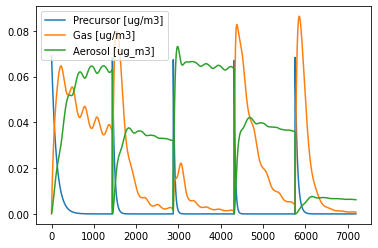

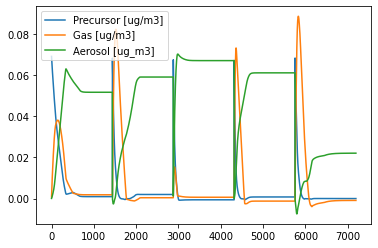

In [ ]:
# model_Dense

pred_nn_Dense = pd.DataFrame(output_scaler.inverse_transform(model_Dense.predict(X_test)))
true_val = test_out.iloc[:,1:-1]

print('Metrics for base model:')
evaluate_mod(true_val, pred_nn_Dense)

print('\nMetrics for Box Emulator:')
evaluate_mod(true_box_Dense, pred_box_Dense)
print("\n")

## Quick plot to see if emulator is capturing the patterns
true_box_Dense.plot()
pred_box_Dense.iloc[:,0:3].plot()
plt.savefig("Time_Series_Model_Dense.png")

Metrics for base model:
RMSE: Precursor: 0.00007, Gas: 0.00013, Aerosols: 0.00009
R2: Precursor: 0.99998, Gas: 0.99997, Aerosols: 0.99999
Hellenger Distance: Precursor: 0.00001, Gas: 0.00002, Aerosols: 0.00006

Metrics for Box Emulator:
RMSE: Precursor: 0.00801, Gas: 0.03918, Aerosols: 0.02475
R2: Precursor: 0.53582, Gas: 0.14080, Aerosols: 0.53372
Hellenger Distance: Precursor: 0.08400, Gas: 0.21544, Aerosols: 0.63566




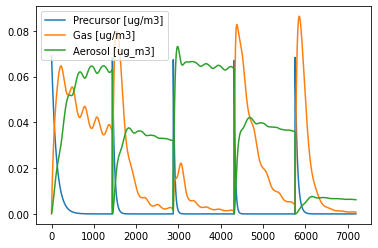

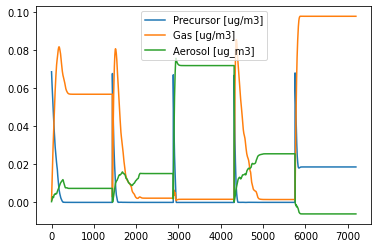

In [ ]:
## model_Dense2

pred_nn_Dense2 = pd.DataFrame(output_scaler.inverse_transform(model_Dense2.predict(X_test)))
true_val = test_out.iloc[:,1:-1]

print('Metrics for base model:')
evaluate_mod(true_val, pred_nn_Dense2)

print('\nMetrics for Box Emulator:')
evaluate_mod(true_box_Dense2, pred_box_Dense2)
print("\n")

## Quick plot to see if emulator is capturing the patterns
true_box_Dense2.plot()
pred_box_Dense2.iloc[:,0:3].plot()
plt.savefig("Time_Series_Model_Dense2.png")

Metrics for base model:
RMSE: Precursor: 0.00005, Gas: 0.00005, Aerosols: 0.00012
R2: Precursor: 0.99999, Gas: 1.00000, Aerosols: 1.00000
Hellenger Distance: Precursor: 0.00000, Gas: 0.00000, Aerosols: 0.00011

Metrics for Box Emulator:
RMSE: Precursor: 56610587423.81949, Gas: 4047798970031.51270, Aerosols: 327537867216.90002
R2: Precursor: 0.00087, Gas: 0.00928, Aerosols: 0.01984
Hellenger Distance: Precursor: 0.01139, Gas: 0.00979, Aerosols: 0.02111




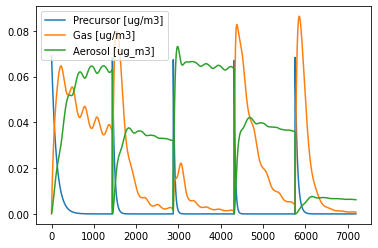

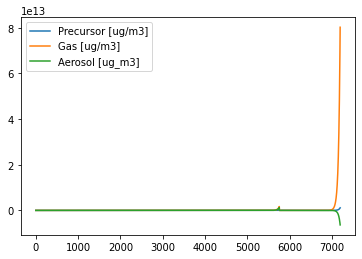

In [ ]:
## model_Dense3

pred_nn_Dense3 = pd.DataFrame(output_scaler.inverse_transform(model_Dense3.predict(X_test)))
true_val = test_out.iloc[:,1:-1]

print('Metrics for base model:')
evaluate_mod(true_val, pred_nn_Dense3)

print('\nMetrics for Box Emulator:')
evaluate_mod(true_box_Dense3, pred_box_Dense3)
print("\n")

## Quick plot to see if emulator is capturing the patterns
true_box_Dense3.plot()
pred_box_Dense3.iloc[:,0:3].plot()
plt.savefig("Time_Series_Model_Dense3.png")

Metrics for base model:
RMSE: Precursor: 0.00018, Gas: 0.00064, Aerosols: 0.00018
R2: Precursor: 0.99971, Gas: 0.99985, Aerosols: 0.99995
Hellenger Distance: Precursor: 0.00014, Gas: 0.00029, Aerosols: 0.00015
Metrics for Box Emulator:
RMSE: Precursor: 0.02590, Gas: 0.02835, Aerosols: 0.02158
R2: Precursor: 0.10075, Gas: 0.03452, Aerosols: 0.49946
Hellenger Distance: Precursor: 0.36842, Gas: 0.31388, Aerosols: 0.57701




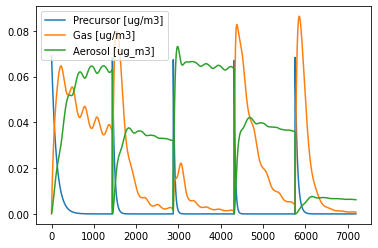

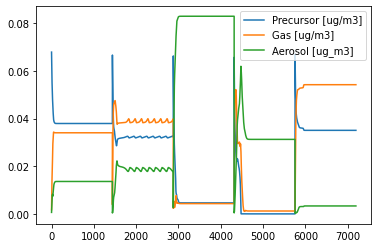

In [ ]:
## model_Dense4

pred_nn_Dense4 = pd.DataFrame(output_scaler.inverse_transform(model_Dense4.predict(X_test)))
true_val = test_out.iloc[:,1:-1]

print('Metrics for base model:')
evaluate_mod(true_val, pred_nn_Dense4)

print('Metrics for Box Emulator:')
evaluate_mod(true_box_Dense4, pred_box_Dense4)
print("\n")

## Quick plot to see if emulator is capturing the patterns
true_box_Dense4.plot()
pred_box_Dense4.iloc[:,0:3].plot()
plt.savefig("Time_Series_Model_Dense4.png")

Now train and evaluate RNN models.

In [ ]:
X_train_now = np.copy(X_train).reshape(X_train.shape[0], 1, X_train.shape[1])
X_validate_now = np.copy(X_validate).reshape(X_validate.shape[0], 1, X_validate.shape[1])
X_test_now = np.copy(X_test).reshape(X_test.shape[0], 1, X_test.shape[1])

In [ ]:
tf.random.set_seed(seed)
model_cuDNN = Model_cuDNN()
model_cuDNN.summary()
history = model_cuDNN.fit(X_train_now, y_train, validation_data=(X_validate_now, y_validate), batch_size=256, epochs=10, verbose=1)

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 128)               70656     
_________________________________________________________________
dense_87 (Dense)             (None, 3)                 387       
Total params: 71,043
Trainable params: 71,043
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
7870/7870 [==============================] - 42s 5ms/step - loss: 4.5126e-04 - accuracy: 0.9950 - val_loss: 1.1699e-06 - val_accuracy: 0.9985
Epoch 2/10
7870/7870 [==============================] - 41s 5ms/step - loss: 6.7334e-07 - accuracy: 0.9992 - val_loss: 3.7486e-07 - val_accuracy: 0.9997
Epoch 3/10
7870/7870 [==============================] - 43s 5ms/step - loss: 5.7599e-07 - accuracy: 0.9992 - val_loss: 6.2153e-07 - val_accuracy: 0.9989
Epoch 4/10
7870/7870 [==============================]

In [ ]:
tf.random.set_seed(seed)
model_LSTM = Model_LSTM()
model_LSTM.summary()
history = model_LSTM.fit(X_train_now, y_train, validation_data=(X_validate_now, y_validate), batch_size=256, epochs=10, verbose=1)

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_7 (LSTM)                (None, 1, 100)            44000     
_________________________________________________________________
lstm_8 (LSTM)                (None, 1, 100)            80400     
_________________________________________________________________
lstm_9 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_88 (Dense)             (None, 3)                 303       
Total params: 205,103
Trainable params: 205,103
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
7870/7870 [==============================] - 158s 20ms/step - loss: 0.0160 - accuracy: 0.8698 - val_loss: 9.0310e-04 - val_accuracy: 0.9816
Epoch 2/10
7870/7870 [==============================] - 154s 20ms/step - loss: 4.9039e-04 - acc

In [ ]:
tf.random.set_seed(seed)
model_LSTM2 = Model_LSTM2()
model_LSTM2.summary()
history = model_LSTM.fit(X_train_now, y_train, validation_data=(X_validate_now, y_validate), batch_size=256, epochs=10, verbose=1)

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_10 (LSTM)               (None, 128)               70656     
_________________________________________________________________
dense_89 (Dense)             (None, 256)               33024     
_________________________________________________________________
dense_90 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_91 (Dense)             (None, 3)                 387       
Total params: 136,963
Trainable params: 136,963
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
7870/7870 [==============================] - 153s 19ms/step - loss: 1.9188e-07 - accuracy: 0.9995 - val_loss: 1.7172e-07 - val_accuracy: 0.9996
Epoch 2/10
7870/7870 [==============================] - 155s 20ms/step - loss: 1.7822e-07 -

In [ ]:
tf.random.set_seed(seed)
model_cuDNN2 = Model_cuDNN2()
model_cuDNN2.summary()
history = model_cuDNN2.fit(X_train_now, y_train, validation_data=(X_validate_now, y_validate), batch_size=256, epochs=10, verbose=1)

In [ ]:
random.seed(seed)
pred_box_cuDNN, true_box_cuDNN = run_emulator_ensemble2(test_in, test_out, model_cuDNN, num_exps, input_vars, input_scaler, output_scaler)

In [ ]:
random.seed(seed)
pred_box_LSTM, true_box_LSTM = run_emulator_ensemble2(test_in, test_out, model_LSTM, num_exps, input_vars, input_scaler, output_scaler)

In [ ]:
random.seed(seed)
pred_box_LSTM2, true_box_LSTM2 = run_emulator_ensemble2(test_in, test_out, model_LSTM2, num_exps, input_vars, input_scaler, output_scaler)

Metrics for base model:
RMSE: Precursor: 0.00003, Gas: 0.00008, Aerosols: 0.00004
R2: Precursor: 1.00000, Gas: 1.00000, Aerosols: 1.00000
Hellenger Distance: Precursor: 0.00000, Gas: 0.00002, Aerosols: 0.00000
Metrics for Box Emulator:
RMSE: Precursor: 0.00377, Gas: 0.03379, Aerosols: 0.02400
R2: Precursor: 0.91294, Gas: 0.57065, Aerosols: 0.69842
Hellenger Distance: Precursor: 0.06289, Gas: 0.49109, Aerosols: 0.27553




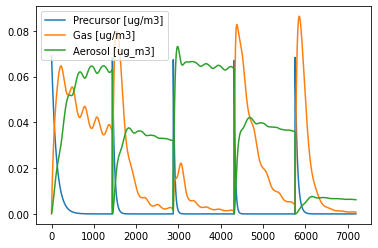

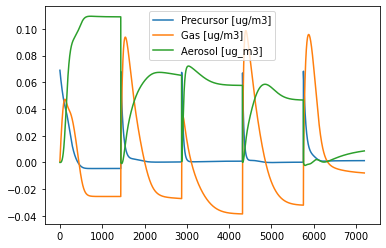

In [ ]:
## model_cuDNN

pred_nn_cuDNN = pd.DataFrame(output_scaler.inverse_transform(model_cuDNN.predict(X_test_now)))
true_val = test_out.iloc[:,1:-1]

print('Metrics for base model:')
evaluate_mod(true_val, pred_nn_cuDNN)

print('Metrics for Box Emulator:')
evaluate_mod(true_box_cuDNN, pred_box_cuDNN)
print("\n")

## Quick plot to see if emulator is capturing the patterns
true_box_cuDNN.plot()
pred_box_cuDNN.iloc[:,0:3].plot()
plt.savefig("Time_Series_Model_CuRSTM.png", bbox_inches="tight")

Metrics for base model:
RMSE: Precursor: 0.00002, Gas: 0.00004, Aerosols: 0.00003
R2: Precursor: 1.00000, Gas: 1.00000, Aerosols: 1.00000
Hellenger Distance: Precursor: 0.00000, Gas: 0.00000, Aerosols: 0.00000
Metrics for Box Emulator:
RMSE: Precursor: 0.01089, Gas: 0.02628, Aerosols: 0.02122
R2: Precursor: 0.32342, Gas: 0.16162, Aerosols: 0.67904
Hellenger Distance: Precursor: 0.00773, Gas: 0.15272, Aerosols: 0.41143




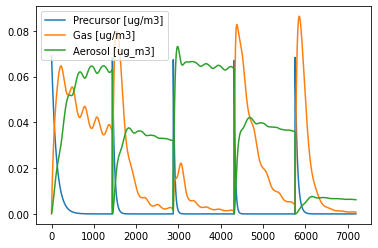

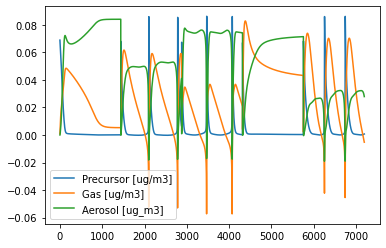

In [ ]:
## model_LSTM

pred_nn_LSTM = pd.DataFrame(output_scaler.inverse_transform(model_LSTM.predict(X_test_now)))
true_val = test_out.iloc[:,1:-1]

print('Metrics for base model:')
evaluate_mod(true_val, pred_nn_LSTM)

print('Metrics for Box Emulator:')
evaluate_mod(true_box_LSTM, pred_box_LSTM)
print("\n")

## Quick plot to see if emulator is capturing the patterns
true_box_LSTM.plot()
pred_box_LSTM.iloc[:,0:3].plot()
plt.savefig("Time_Series_RSTM.png")

Metrics for base model:
RMSE: Precursor: 0.01065, Gas: 0.03355, Aerosols: 0.04304
R2: Precursor: 0.03897, Gas: 0.02337, Aerosols: 0.42484
Hellenger Distance: Precursor: 0.21342, Gas: 0.51937, Aerosols: 0.95260
Metrics for Box Emulator:
RMSE: Precursor: 0.00939, Gas: 0.03396, Aerosols: 0.04590
R2: Precursor: 0.01813, Gas: 0.08016, Aerosols: 0.02329
Hellenger Distance: Precursor: 0.23239, Gas: 0.80297, Aerosols: 0.84644




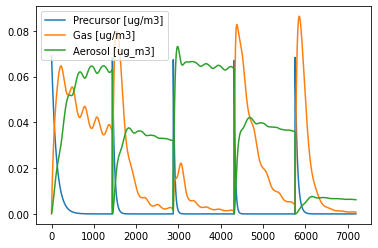

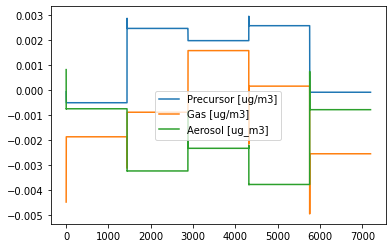

In [ ]:
## model_LSTM2

pred_nn_LSTM2 = pd.DataFrame(output_scaler.inverse_transform(model_LSTM2.predict(X_test_now)))
true_val = test_out.iloc[:,1:-1]

print('Metrics for base model:')
evaluate_mod(true_val, pred_nn_LSTM2)

print('Metrics for Box Emulator:')
evaluate_mod(true_box_LSTM2, pred_box_LSTM2)
print("\n")

## Quick plot to see if emulator is capturing the patterns
true_box_LSTM2.plot()
pred_box_LSTM2.iloc[:,0:3].plot()
plt.savefig("Time_Series_RSTM2.png")

Now train and evaluate CNN models.

In [ ]:
X_train_now = np.copy(X_train).reshape(X_train.shape[0], X_train.shape[1], 1)
X_validate_now = np.copy(X_validate).reshape(X_validate.shape[0], X_validate.shape[1], 1)
X_test_now = np.copy(X_test).reshape(X_test.shape[0], 1, X_test.shape[1], 1)

In [ ]:
tf.random.set_seed(seed)
model_Conv1D = Model_Conv1D()
model_Conv1D.summary()
history = model_Conv1D.fit(X_train_now, y_train, validation_data=(X_validate_now, y_validate), batch_size=256, epochs=10, verbose=1)

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_3 (Conv1D)            (None, 4, 32)             224       
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 2, 32)             3104      
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 1, 32)             2080      
_________________________________________________________________
flatten_1 (Flatten)          (None, 32)                0         
_________________________________________________________________
dense_92 (Dense)             (None, 100)               3300      
_________________________________________________________________
batch_normalization_1 (Batch (None, 100)               400       
_________________________________________________________________
dense_93 (Dense)             (None, 3)                

In [ ]:
random.seed(seed)
pred_box_Conv1D, true_box_Conv1D = run_emulator_ensemble3(test_in, test_out, model_Conv1D, num_exps, input_vars, input_scaler, output_scaler)

In [ ]:
## model_Conv1D

pred_nn_Conv1D = pd.DataFrame(output_scaler.inverse_transform(model_Conv1D.predict(X_test_now)))
true_val = test_out.iloc[:,1:-1]

print('Metrics for base model:')
evaluate_mod(true_val, pred_nn_Conv1D)

print('Metrics for Box Emulator:')
evaluate_mod(true_box_Conv1D, pred_box_Conv1D)
print("\n")

## Quick plot to see if emulator is capturing the patterns
true_box_Conv1D.plot()
pred_box_Conv1D.iloc[:,0:3].plot()
plt.savefig("Time_Series_Conv1D.png")

In [ ]:
# Some trials to test and evaluate features used in this analysis.

# feature importance of the random forest model
feature_importance = pd.DataFrame()
feature_importance['variable'] = train_in.iloc[:,1:-1].columns
feature_importance['importance'] = rf_model.feature_importances_
# feature_importance values in descending order
feature_importance.sort_values(by='importance', ascending=False).head(10)
# creating the explainer function
explainer = LimeTabularExplainer(X_train, mode="regression", feature_names=train_in.iloc[:,1:-1].columns)
# storing a new observation
i = 6
X_observation = X_test[[i], :]
print('RF prediction:{}'.format(rf_model.predict(X_observation)[0, 0]))
# explanation using the random forest model
explanation = explainer.explain_instance(X_observation[0], rf_model.predict)
explanation.show_in_notebook(show_table=True, show_all=False)
print(explanation.score)

# import Explainer function from lime_tabular module of lime library
from lime.lime_tabular import LimeTabularExplainer
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import tensorflow as tf
# Load data
fs = s3fs.S3FileSystem(anon=True)
gecko_files = fs.ls("ncar-aiml-data-commons/gecko/")[1:]
test, train, val = map(fetch_data, gecko_files)
# Drop some unnecessary columns, and apply scalers
input_vars, output_vars = train.columns, train.columns[[0,1,2,3,-1]]
train_in, train_out = prepare_data(train, input_vars, output_vars)
val_in, val_out = prepare_data(val, input_vars, output_vars)
test_in, test_out = prepare_data(test, input_vars, output_vars)
input_scaler = MinMaxScaler()
output_scaler = MinMaxScaler()
scaled_train_in = input_scaler.fit_transform(train_in.iloc[:,1:-1])
scaled_train_out = output_scaler.fit_transform(train_out.iloc[:,1:-1])
scaled_val_in = input_scaler.transform(val_in.iloc[:,1:-1])
scaled_val_out = output_scaler.transform(val_out.iloc[:,1:-1])
scaled_test_in = input_scaler.transform(test_in.iloc[:,1:-1])
scaled_test_out = output_scaler.transform(test_out.iloc[:,1:-1])
X_train = np.copy(scaled_train_in)
y_train = np.copy(scaled_train_out)
X_validate = np.copy(scaled_val_in)
y_validate = np.copy(scaled_val_out)
X_test = np.copy(scaled_test_in)
y_test = np.copy(scaled_test_out)
# training the random forest model
rf_model = RandomForestRegressor(n_estimators=200,max_depth=5, min_samples_leaf=100,n_jobs=-1, random_state=10, criterion="mse", bootstrap=True, verbose=1)
rf_model.fit(X_train, y_train)
# feature importance of the random forest model
feature_importance = pd.DataFrame()
feature_importance['variable'] = train_in.iloc[:,1:-1].columns
feature_importance['importance'] = rf_model.feature_importances_
# feature_importance values in descending order
feature_importance.sort_values(by='importance', ascending=False).head(10)
# creating the explainer function
explainer = LimeTabularExplainer(X_train, mode="regression", feature_names=train_in.iloc[:,1:-1].columns)
# storing a new observation
i = 6
X_observation = X_test[[i], :]
print('RF prediction:{}'.format(rf_model.predict(X_observation)[0, 0]))
# explanation using the random forest model
explanation = explainer.explain_instance(X_observation[0], rf_model.predict)
explanation.show_in_notebook(show_table=True, show_all=False)
print(explanation.score)